In [2]:
#TP 3 GRUPO 7
#DOLIMPIO - FEIJOO - RUDI

# ================================
# RUDI PUNTO A
# Modelo de regresión logística con regularización (Ridge y LASSO)
# ================================

# Celda 1: imports generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [3]:
# Celda 2: cargar base y armar respondieron_2025
# (ajustar el path si fuera necesario)
df = pd.read_csv(
    r"C:\Users\gasto\Desktop\Taller de Programación\TP4\panel_tp3_limpio_con_pobreza.csv"
)

# Filtro: año 2025 + respondieron ITF + IPCF no nulo
respondieron_2025 = df[
    (df["ANIO"] == 2025) &
    (df["RESPONDIO_ITF"] == 1) &
    (df["IPCF"].notna())
].copy()

print("Tamaño de respondieron_2025:", respondieron_2025.shape)

Tamaño de respondieron_2025: (4134, 34)


In [8]:
# Celda 3: definir variables explicativas y target

features = [
    "CH04",     # sexo
    "CH06",     # edad
    "CH07",     # estado civil
    "CH08",     # cobertura médica
    "NIVEL_ED", # nivel educativo
    "ESTADO",   # condición de actividad
    "CAT_INAC", # categoría de inactividad
    "IPCF",     # ingreso per cápita familiar
    "PP04A"     # institución trabajo estatal/privada
]

TARGET = "POBRE"

# Filtramos df, no respondieron_2025
data = df[features + [TARGET]].dropna().copy()

X = data[features].values
y = data[TARGET].values

# Estándar según lo que después usa el código (X_scaled)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

feature_names = features

print("Dimensión X:", X.shape)
print("Dimensión y:", y.shape)
print("Proporción de pobres:", y.mean())

Dimensión X: (5495, 9)
Dimensión y: (5495,)
Proporción de pobres: 0.26096451319381253


In [9]:
# Celda 4: train-test split y estandarización
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=123,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Tamaño X_train:", X_train_scaled.shape)
print("Tamaño X_test:", X_test_scaled.shape)

Tamaño X_train: (3846, 9)
Tamaño X_test: (1649, 9)


In [10]:
# Celda 5: grilla de lambdas y C
# λ = 10^n, para n = -5, -4, ..., 5
n_vals = np.arange(-5, 6)              # [-5, -4, ..., 5]
lambdas = 10.0 ** n_vals               # λ
C_values = 1.0 / lambdas               # C = 1 / λ

print("λ:", lambdas)
print("C:", C_values)

λ: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
C: [1.e+05 1.e+04 1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04
 1.e-05]


In [11]:
# Celda 6: trayectorias de coeficientes para L1 (LASSO) y L2 (Ridge)
coef_lasso = []
coef_ridge = []

for C in C_values:
    # LASSO (penalidad L1)
    logit_l1 = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',
        max_iter=5000
    )
    logit_l1.fit(X_scaled, y)
    coef_lasso.append(logit_l1.coef_.ravel())   # (n_features,)

    # Ridge (penalidad L2)
    logit_l2 = LogisticRegression(
        penalty='l2',
        C=C,
        solver='liblinear',
        max_iter=5000
    )
    logit_l2.fit(X_scaled, y)
    coef_ridge.append(logit_l2.coef_.ravel())

coef_lasso = np.array(coef_lasso)
coef_ridge = np.array(coef_ridge)

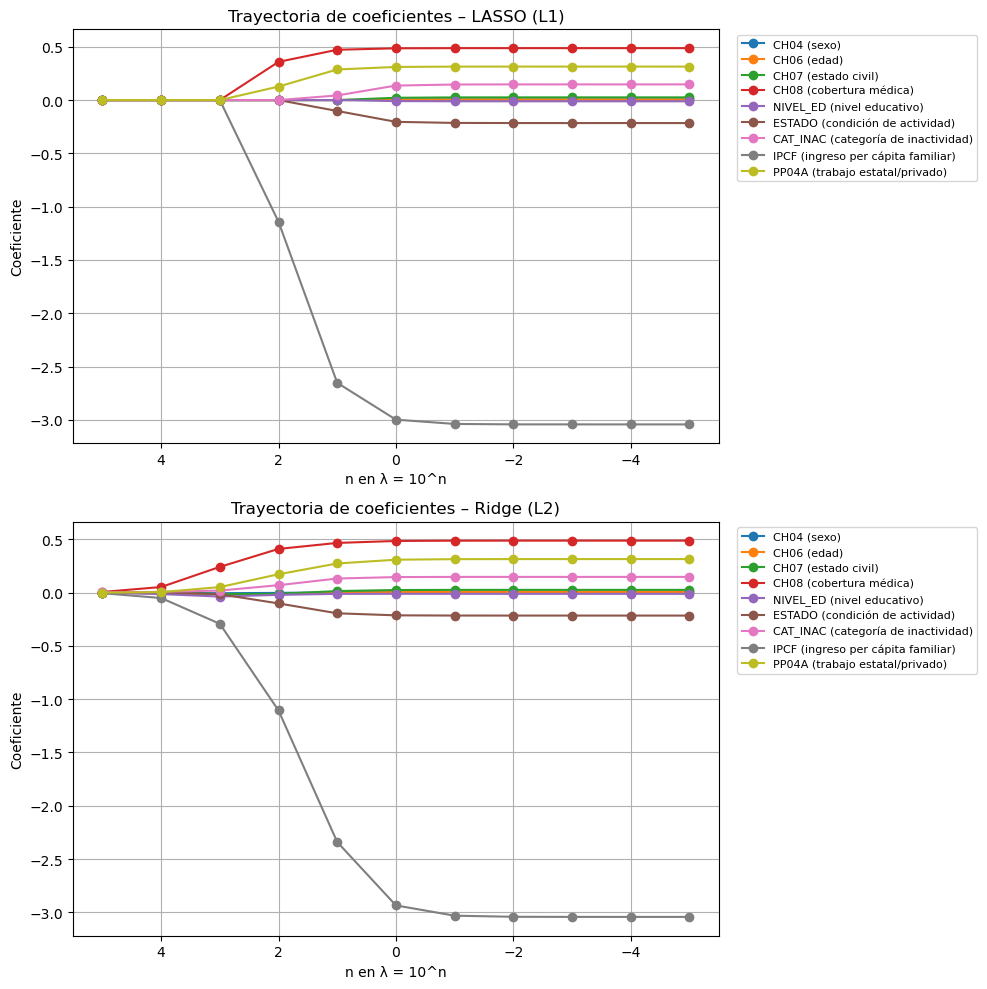

In [13]:
# Celda 7: gráficos de coeficientes vs n (log10 λ)

import matplotlib.pyplot as plt

# Mapeo descriptivo para mostrar "CH04 (sexo)" etc.
label_map = {
    "CH04": "sexo",
    "CH06": "edad",
    "CH07": "estado civil",
    "CH08": "cobertura médica",
    "NIVEL_ED": "nivel educativo",
    "ESTADO": "condición de actividad",
    "CAT_INAC": "categoría de inactividad",
    "IPCF": "ingreso per cápita familiar",
    "PP04A": "trabajo estatal/privado"
}

fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # igual al compañero

# -------------------------
# Panel 1: LASSO (L1)
# -------------------------
ax = axes[0]
for j, name in enumerate(feature_names):
    etiqueta = f"{name} ({label_map.get(name, name)})"
    ax.plot(n_vals, coef_lasso[:, j], marker="o", label=etiqueta)

ax.set_title("Trayectoria de coeficientes – LASSO (L1)")
ax.set_xlabel("n en λ = 10^n")
ax.set_ylabel("Coeficiente")
ax.invert_xaxis()   # igual que tu compañero
ax.grid(True)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)

# -------------------------
# Panel 2: Ridge (L2)
# -------------------------
ax = axes[1]
for j, name in enumerate(feature_names):
    etiqueta = f"{name} ({label_map.get(name, name)})"
    ax.plot(n_vals, coef_ridge[:, j], marker="o", label=etiqueta)

ax.set_title("Trayectoria de coeficientes – Ridge (L2)")
ax.set_xlabel("n en λ = 10^n")
ax.set_ylabel("Coeficiente")
ax.invert_xaxis()   # igual que tu compañero
ax.grid(True)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

In [16]:
# Celda 8: Cross-validation para LASSO (L1) y Ridge (L2)

from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import matplotlib.pyplot as plt

# Grilla de λ y C
n_vals = np.arange(-5, 6)              # [-5, -4, ..., 5]
lambdas = 10.0 ** n_vals               # λ = 10^n
C_values = 1.0 / lambdas               # C = 1 / λ

print("λ:", lambdas)
print("C:", C_values)

# ----- LASSO (L1) -----
logit_l1_cv = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='accuracy',
    max_iter=5000,
    refit=True
)

logit_l1_cv.fit(X_scaled, y)

# Accuracy promedio entre folds para cada C (clase positiva = 1)
mean_acc_l1 = logit_l1_cv.scores_[1].mean(axis=0)   # shape (n_Cs,)
error_l1 = 1 - mean_acc_l1

# C y λ óptimos
C_opt_l1 = logit_l1_cv.C_[0]
lambda_opt_l1 = 1.0 / C_opt_l1
n_opt_l1 = np.log10(lambda_opt_l1)

print("=== LASSO (L1) ===")
print("C^cv óptimo:", C_opt_l1)
print("λ^cv óptimo:", lambda_opt_l1)
print("n^cv (λ=10^n):", n_opt_l1)

# ----- Ridge (L2) -----
logit_l2_cv = LogisticRegressionCV(
    Cs=C_values,
    cv=5,
    penalty='l2',
    solver='liblinear',   # igual que tu compañero
    scoring='accuracy',
    max_iter=5000,
    refit=True
)

logit_l2_cv.fit(X_scaled, y)

mean_acc_l2 = logit_l2_cv.scores_[1].mean(axis=0)
error_l2 = 1 - mean_acc_l2

C_opt_l2 = logit_l2_cv.C_[0]
lambda_opt_l2 = 1.0 / C_opt_l2
n_opt_l2 = np.log10(lambda_opt_l2)

print("=== Ridge (L2) ===")
print("C^cv óptimo:", C_opt_l2)
print("λ^cv óptimo:", lambda_opt_l2)
print("n^cv (λ=10^n):", n_opt_l2)

λ: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
C: [1.e+05 1.e+04 1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04
 1.e-05]
=== LASSO (L1) ===
C^cv óptimo: 0.001
λ^cv óptimo: 1000.0
n^cv (λ=10^n): 3.0
=== Ridge (L2) ===
C^cv óptimo: 0.0001
λ^cv óptimo: 10000.0
n^cv (λ=10^n): 4.0


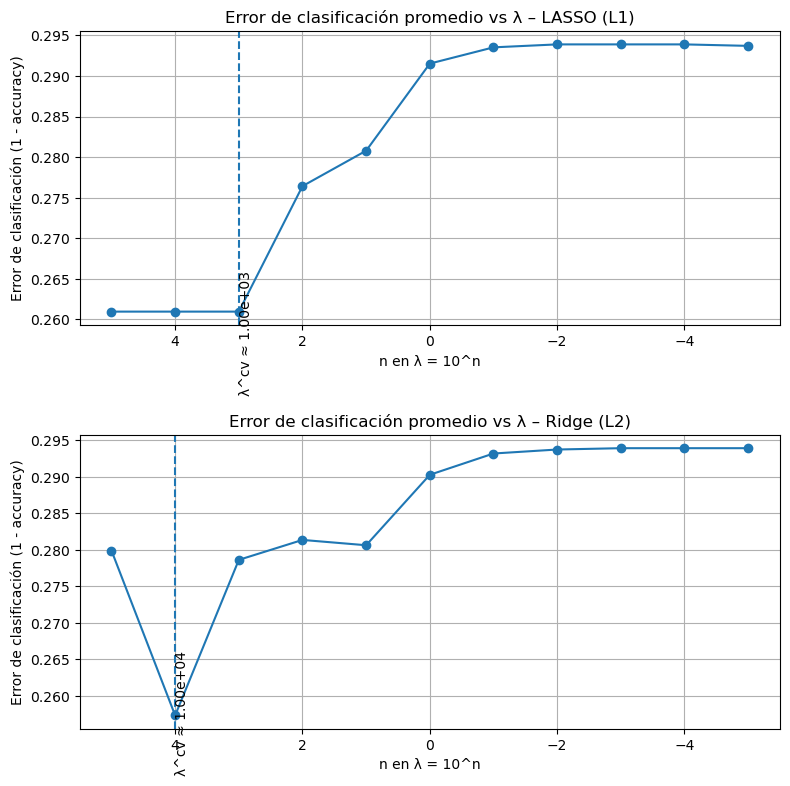

In [17]:
# Celda 9: Error de clasificación promedio vs λ, con λ^cv marcado

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Panel 1: LASSO
ax = axes[0]
ax.plot(n_vals, error_l1, marker='o')
ax.set_title("Error de clasificación promedio vs λ – LASSO (L1)")
ax.set_xlabel("n en λ = 10^n")
ax.set_ylabel("Error de clasificación (1 - accuracy)")
ax.invert_xaxis()        # a la derecha: menor regularización
ax.grid(True)

# marcar λ óptimo
ax.axvline(np.log10(lambda_opt_l1), linestyle='--')
ax.text(np.log10(lambda_opt_l1), ax.get_ylim()[1]*0.9,
        f"λ^cv ≈ {lambda_opt_l1:.2e}",
        rotation=90, va='top')

# Panel 2: Ridge
ax = axes[1]
ax.plot(n_vals, error_l2, marker='o')
ax.set_title("Error de clasificación promedio vs λ – Ridge (L2)")
ax.set_xlabel("n en λ = 10^n")
ax.set_ylabel("Error de clasificación (1 - accuracy)")
ax.invert_xaxis()
ax.grid(True)

ax.axvline(np.log10(lambda_opt_l2), linestyle='--')
ax.text(np.log10(lambda_opt_l2), ax.get_ylim()[1]*0.9,
        f"λ^cv ≈ {lambda_opt_l2:.2e}",
        rotation=90, va='top')

plt.tight_layout()
plt.show()

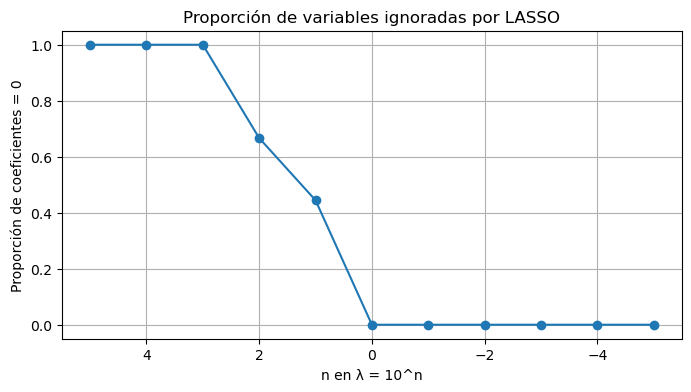

In [18]:
# Celda 10: Proporción de variables ignoradas por LASSO (coeficientes = 0)

from sklearn.linear_model import LogisticRegression

prop_ceros = []

for C in C_values:
    logit_l1 = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',
        max_iter=5000
    )
    logit_l1.fit(X_scaled, y)
    coef = logit_l1.coef_.ravel()
    prop_ceros.append(np.mean(coef == 0))

prop_ceros = np.array(prop_ceros)

plt.figure(figsize=(8, 4))
plt.plot(n_vals, prop_ceros, marker='o')
plt.title("Proporción de variables ignoradas por LASSO")
plt.xlabel("n en λ = 10^n")
plt.ylabel("Proporción de coeficientes = 0")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

In [19]:
# Celda 11: Filtro respondieron_2025 y armado de muestra train/test

# Filtro: año 2025 + respondieron ITF + IPCF no nulo
respondieron_2025 = df[
    (df["ANIO"] == 2025) &
    (df["RESPONDIO_ITF"] == 1) &
    (df["IPCF"].notna())
].copy()

print("respondieron_2025:", respondieron_2025.shape)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = [
    "CH04",     # sexo
    "CH06",     # edad
    "CH07",     # estado civil
    "CH08",     # cobertura médica
    "NIVEL_ED", # nivel educativo
    "ESTADO",   # condición de actividad
    "CAT_INAC", # categoría de inactividad
    "IPCF",     # ingreso per cápita familiar
    "PP04A"     # inst. de trabajo (estatal/privada)
]

TARGET = "POBRE"

data_2025 = respondieron_2025[features + [TARGET]].dropna()
X = data_2025[features].values
y = data_2025[TARGET].values
feature_names = features

print("Datos para modelo:", X.shape, y.shape)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

respondieron_2025: (4134, 34)
Datos para modelo: (1801, 9) (1801,)


In [20]:
# Celda 12: Modelos finales y tabla de coeficientes

from sklearn.linear_model import LogisticRegression

# 1) Logit "sin penalidad" (en realidad L2 con C=1 por default, igual que tu compañero)
logit_np = LogisticRegression(
    solver='lbfgs',
    max_iter=5000
)
logit_np.fit(X_train_scaled, y_train)
coef_np = logit_np.coef_.ravel()

# 2) LASSO (L1) con λ^cv = 1000  → C = 0.001
logit_l1_cv = LogisticRegression(
    penalty='l1',
    C=0.001,
    solver='liblinear',
    max_iter=5000
)
logit_l1_cv.fit(X_train_scaled, y_train)
coef_l1_cv = logit_l1_cv.coef_.ravel()

# 3) Ridge (L2) con λ^cv = 10000 → C = 0.0001
logit_l2_cv = LogisticRegression(
    penalty='l2',
    C=0.0001,
    solver='liblinear',
    max_iter=5000
)
logit_l2_cv.fit(X_train_scaled, y_train)
coef_l2_cv = logit_l2_cv.coef_.ravel()

# Mapeo de etiquetas
label_map = {
    "CH04": "sexo",
    "CH06": "edad",
    "CH07": "estado civil",
    "CH08": "cobertura médica",
    "NIVEL_ED": "nivel educativo",
    "ESTADO": "condición de actividad",
    "CAT_INAC": "categoría de inactividad",
    "IPCF": "ingreso per cápita familiar",
    "PP04A": "inst. de trabajo (estatal/privada)"
}

coef_table = pd.DataFrame({
    "Variable": feature_names,
    "Descripción": [label_map.get(v, v) for v in feature_names],
    "Logit_sin_penalidad": coef_np,
    "L1_λ=1000": coef_l1_cv,
    "L2_λ=10000": coef_l2_cv
})

print(coef_table)

# Exportar
coef_table.to_csv("coeficientes_respondieron2025_logit_penalizados.csv", index=False)
# o:
# coef_table.to_excel("coeficientes_respondieron2025_logit_penalizados.xlsx", index=False)

   Variable                         Descripción  Logit_sin_penalidad  \
0      CH04                                sexo            -0.116005   
1      CH06                                edad            -0.048891   
2      CH07                        estado civil            -0.021665   
3      CH08                    cobertura médica             0.275005   
4  NIVEL_ED                     nivel educativo            -0.088139   
5    ESTADO              condición de actividad             0.000000   
6  CAT_INAC            categoría de inactividad             0.000000   
7      IPCF         ingreso per cápita familiar            -9.972753   
8     PP04A  inst. de trabajo (estatal/privada)             0.040445   

   L1_λ=1000  L2_λ=10000  
0        0.0    0.000216  
1        0.0   -0.002597  
2        0.0   -0.000262  
3        0.0    0.013063  
4        0.0   -0.008883  
5        0.0    0.000000  
6        0.0    0.000000  
7        0.0   -0.012955  
8        0.0    0.006393  


In [24]:
# ================================
# DOLIMPIO PUNTO B
# Árboles de decisión (CART) con poda por costo de complejidad
# ================================

#Celda B1 Cargar librerías

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
# Celda B2: Estimar árbol base y obtener secuencia de poda (ccp_alpha)

# Árbol "grande" inicial (sin poda explícita, salvo min_samples_leaf)
arbol_base = DecisionTreeClassifier(
    criterion="gini",
    random_state=444,    # random state 444
    min_samples_leaf=50  # valor moderado para evitar árboles complicados
)

arbol_base.fit(X_train, y_train)

# Secuencia de costo de complejidad
path = arbol_base.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # grilla de alphas
impurities = path.impurities

print("Cantidad de valores de ccp_alpha:", len(ccp_alphas))
print("Primeros alphas:", ccp_alphas[:10])

Cantidad de valores de ccp_alpha: 4
Primeros alphas: [0.         0.00023998 0.00873349 0.16359509]


In [23]:
# Celda B3: 10-fold Cross-Validation para elegir ccp_alpha óptimo (B.4)

cv = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=444   # mismo random state
)

mean_val_error = []
std_val_error = []

for alpha in ccp_alphas:
    arbol_cv = DecisionTreeClassifier(
        criterion="gini",
        random_state=444,
        min_samples_leaf=50,
        ccp_alpha=alpha
    )
    
    errores_folds = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        arbol_cv.fit(X_tr, y_tr)
        y_pred_val = arbol_cv.predict(X_val)
        
        error_val = 1 - accuracy_score(y_val, y_pred_val)
        errores_folds.append(error_val)
    
    mean_val_error.append(np.mean(errores_folds))
    std_val_error.append(np.std(errores_folds))

mean_val_error = np.array(mean_val_error)
std_val_error = np.array(std_val_error)

# Índice y valor de alpha óptimo
idx_best = np.argmin(mean_val_error)
alpha_opt = ccp_alphas[idx_best]

print(f"Mejor ccp_alpha según 10-fold CV: {alpha_opt:.6f}")
print(f"Error de clasificación promedio en el mejor alpha: {mean_val_error[idx_best]:.4f}")

Mejor ccp_alpha según 10-fold CV: 0.000000
Error de clasificación promedio en el mejor alpha: 0.0278


In [25]:
# Celda B5: Ajustar árbol podado con ccp_alpha óptimo y evaluar en train y test

arbol_podado = DecisionTreeClassifier(
    criterion="gini",
    random_state=444,
    min_samples_leaf=50,
    ccp_alpha=alpha_opt
)

arbol_podado.fit(X_train, y_train)

# Predicciones
y_pred_train = arbol_podado.predict(X_train)
y_pred_test = arbol_podado.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"Accuracy en TRAIN (árbol podado): {acc_train:.4f}")
print(f"Accuracy en TEST  (árbol podado): {acc_test:.4f}")
print(f"Error en TEST (1 - accuracy): {1 - acc_test:.4f}")

Accuracy en TRAIN (árbol podado): 0.9771
Accuracy en TEST  (árbol podado): 0.9834
Error en TEST (1 - accuracy): 0.0166


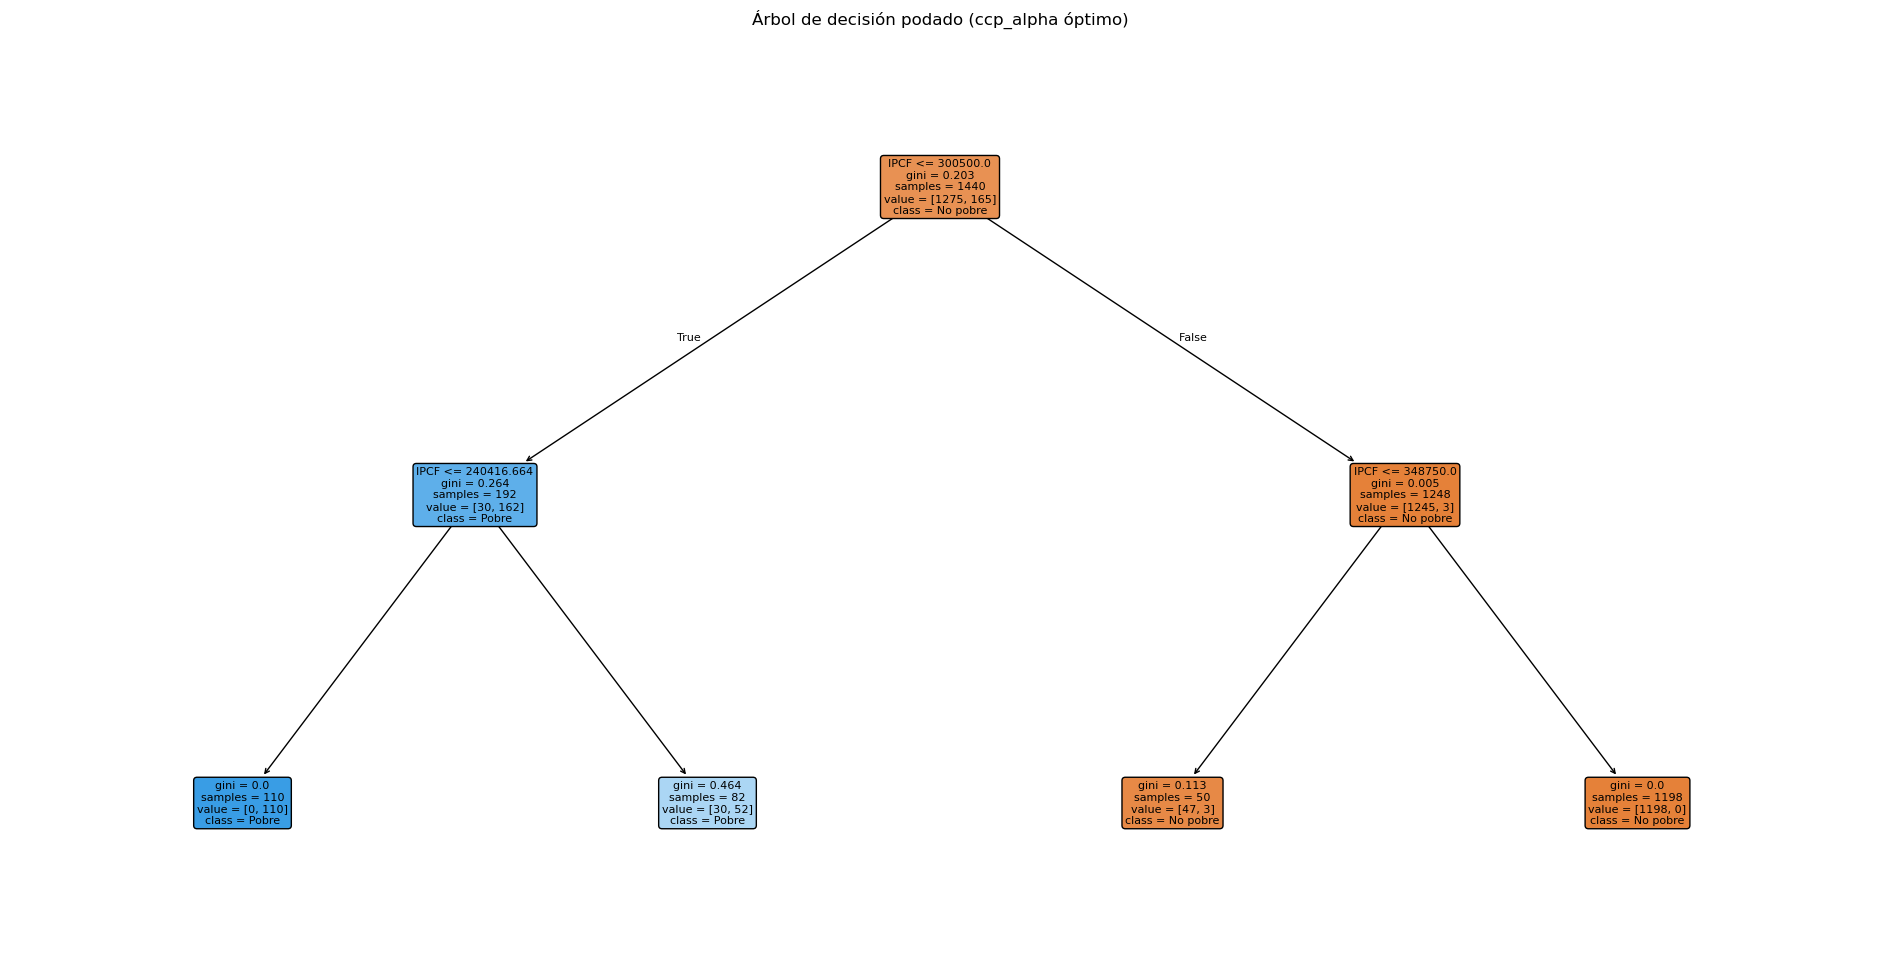

In [31]:
# Celda B6: Panel A - Visualización del árbol podado

plt.figure(figsize=(24, 12))
plot_tree(
    arbol_podado,
    feature_names=feature_names,
    class_names=["No pobre", "Pobre"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Árbol de decisión podado (ccp_alpha óptimo)")

# ---- Guardar en PNG en carpeta Downloads ----
plt.savefig(
    r"C:\Users\gasto\Downloads\arbol_podado.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

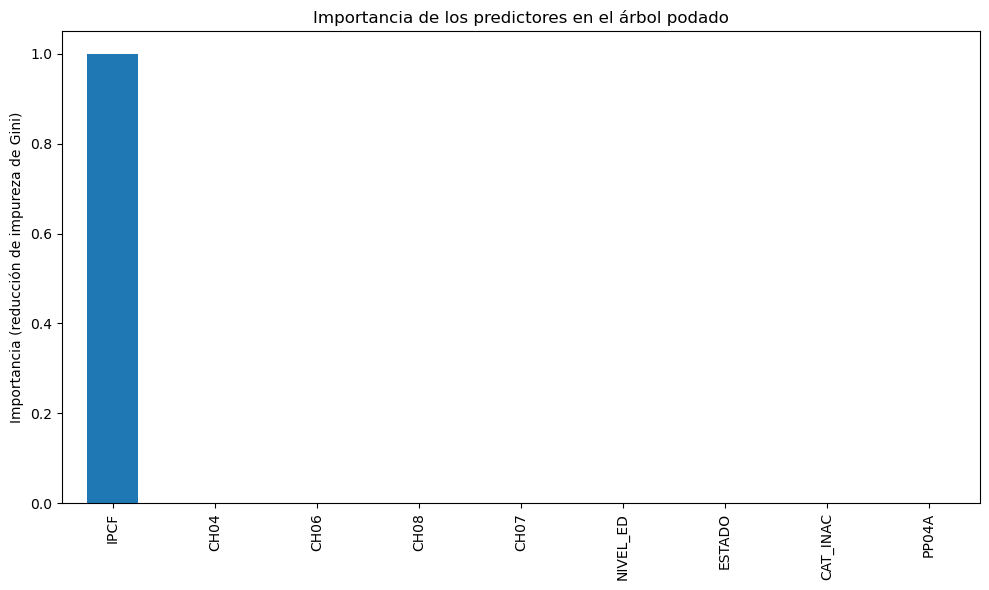

,variable,importancia_gini
0,IPCF,1.0
1,CH04,0.0
2,CH06,0.0
3,CH08,0.0
4,CH07,0.0
5,NIVEL_ED,0.0
6,ESTADO,0.0
7,CAT_INAC,0.0
8,PP04A,0.0


In [32]:
# Celda B7: Panel B - Importancia de variables (B.5)

importancias = pd.Series(
    arbol_podado.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importancias.plot(kind="bar")
plt.ylabel("Importancia (reducción de impureza de Gini)")
plt.title("Importancia de los predictores en el árbol podado")
plt.xticks(rotation=90)
plt.tight_layout()

# ---- Guardar gráfico en PNG ----
plt.savefig(
    r"C:\Users\gasto\Downloads\importancia_variables_arbol.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()

# Tabla opcional para comparar contra LASSO en el informe
tabla_importancias = importancias.reset_index()
tabla_importancias.columns = ["variable", "importancia_gini"]
display(tabla_importancias)

# ---- Guardar tabla en CSV ----
tabla_importancias.to_csv(
    r"C:\Users\gasto\Downloads\tabla_importancias_arbol.csv",
    index=False
)

# ---- Guardar tabla en Excel (opcional) ----
tabla_importancias.to_excel(
    r"C:\Users\gasto\Downloads\tabla_importancias_arbol.xlsx",
    index=False
)

In [ ]:
# ================================
# FEIJOO PUNTO C
# ================================

In [ ]:
# librerias con las que se va a trabajar\n",
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('C:/Users/ASUS Vivobook/Documents/GitHub/BigDataUBA-Grupo5/TP3/panel_tp3_limpio_con_pobreza.csv')
df.head()

In [ ]:
conteo_itf_cero = (df['ITF'] == 0).sum()
print(f"El número de observaciones con ITF = 0 en df es: {conteo_itf_cero}")

# Filtramos solo quienes respondieron ITF y pertenecen al año 2025
df_2025_itf = df[(df['RESPONDIO_ITF'] == 1) & (df['ANO4'] == 2025)]
df_2025_itf.head()

# Calcular los cuartiles y el IQR para ITF e IPCF
Q1_ITF = df_2025_itf["ITF"].quantile(0.25)
Q3_ITF = df_2025_itf["ITF"].quantile(0.75)
IQR_ITF = Q3_ITF - Q1_ITF

Q1_IPCF = df_2025_itf["IPCF"].quantile(0.25)
Q3_IPCF = df_2025_itf["IPCF"].quantile(0.75)
IQR_IPCF = Q3_IPCF - Q1_IPCF

# Filtrar outliers (quedarnos con los valores dentro del rango intercuartílico)
df_2025_itf_filtered = df_2025_itf[((df_2025_itf["ITF"] >= (Q1_ITF - 1.5 * IQR_ITF)) & (df_2025_itf["ITF"] <= (Q3_ITF + 1.5 * IQR_ITF))) &
                                   ((df_2025_itf["IPCF"] >= (Q1_IPCF - 1.5 * IQR_IPCF)) & (df_2025_itf["IPCF"] <= (Q3_IPCF + 1.5 * IQR_IPCF)))]

print(f"Filas antes de eliminar outliers: {df_2025_itf.shape[0]}")
print(f"Filas después de eliminar outliers: {df_2025_itf_filtered.shape[0]}")

# Usamos el mismo proceso para graficar después de filtrar los outliers
df_2025_itf_subset_filtered = df_2025_itf_filtered  # Variables numéricas sin outliers

In [ ]:
df_2025_itf_subset_filtered.head()

# Variable objetivo
y = df_2025_itf_subset_filtered["POBRE"]

# Features
features = [
    "CH04", "CH06", "CH07", "CH08", "CH12", "CH13", "NIVEL_ED", "ESTADO",
    "CAT_INAC", "ITF", "IPCF"
]

X = df_2025_itf_subset_filtered[features]

# Pasamos las categóricas a dummies
cat_cols = ["CH04", "CH07", "CH08", "CH12", "CH13", "NIVEL_ED", "ESTADO", "CAT_INAC"]

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=444,
    stratify=y
)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

logit_model = LogisticRegression(
    random_state=444, 
    max_iter=1000, 
    solver='liblinear' #para datasets pequeños
)

# 2. Entrenar el modelo con los datos de entrenamiento
print("Entrenando el modelo...")
logit_model.fit(X_train, y_train)
print("¡Entrenamiento finalizado!")

# 3. Realizar predicciones sobre el conjunto de prueba (X_test)
y_pred = logit_model.predict(X_test)

# Reporte de clasificación
print("\n## 📋 Reporte de Clasificación")
print(classification_report(y_test, y_pred))

# Precisión general del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión (Accuracy) del Modelo: {accuracy:.4f}")

In [ ]:
# Definimos los valores de K para los que vamos a realizar la validación cruzada
K_values = [1, 10]

# Creamos el escalador y escalamos X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # X_train_subset es el conjunto sin outliers
y_train_subset = y_train  # Etiquetas

# Lista para almacenar el accuracy promedio de cada K
mean_accuracies = []

# Aplicamos validación cruzada (5-fold) para cada valor de K
for k in K_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Realizamos la validación cruzada y calculamos el accuracy promedio
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracies.append(np.mean(cv_scores))  # Guardamos el accuracy promedio

# Graficamos el accuracy promedio para cada K
plt.figure(figsize=(8, 6))
plt.plot(K_values, mean_accuracies, marker='o', color='b', linestyle='-', markersize=8)
plt.title('Accuracy Promedio por Cross-Validation para KNN')
plt.xlabel('Número de Vecinos (K)')
plt.ylabel('Accuracy Promedio')
plt.xticks(K_values)
plt.grid(True)
plt.show()

# Mostramos el K óptimo
optimal_k = K_values[np.argmax(mean_accuracies)]
print(f"El K óptimo por Cross-Validation es: K={optimal_k}")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# El K óptimo que determinaste
K_OPTIMO = 1

# 1. Escalar el conjunto de prueba (X_test)
# ¡CRUCIAL! Se aplica el mismo 'scaler' ajustado en el entrenamiento, usando solo .transform()
X_test_scaled = scaler.transform(X_test)

# 2. Inicializar y Entrenar el modelo KNN con K=1
knn_model_optimo = KNeighborsClassifier(n_neighbors=K_OPTIMO)

print(f"Entrenando el modelo KNN con K={K_OPTIMO}...")
# Usamos los datos de entrenamiento ya escalados (X_train_scaled)
knn_model_optimo.fit(X_train_scaled, y_train_subset)
print("¡Entrenamiento finalizado!")

# 3. Realizar predicciones sobre el conjunto de prueba escalado
y_pred_optimo = knn_model_optimo.predict(X_test_scaled)

# 4. Generar la Matriz de Confusión
cm_optimo = confusion_matrix(y_test, y_pred_optimo)

print("\n## 🔳 Matriz de Confusión para KNN (K=1)")
print("Predicciones vs. Valores Reales:")
print(cm_optimo)

# 5. Calcular la Precisión (Accuracy) general
accuracy = accuracy_score(y_test, y_pred_optimo)
print(f"\nPrecisión (Accuracy) en el conjunto de prueba: {accuracy:.4f}")

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Obtener las probabilidades de predicción para la clase positiva (Clase 1, "Pobre")
# El método predict_proba devuelve las probabilidades para [Clase 0, Clase 1]
# Tomamos solo la columna 1 (probabilidad de ser "Pobre")
y_pred_proba_logit = logit_model.predict_proba(X_test)[:, 1]

# 2. Calcular el Área Bajo la Curva (AUC)
# Esta métrica mide la capacidad discriminatoria del modelo.
roc_auc_logit = roc_auc_score(y_test, y_pred_proba_logit)

print(f"\n## 🔢 Métrica AUC para el Modelo Logit")
print(f"El Área Bajo la Curva (AUC) es: {roc_auc_logit:.4f}")

# 3. Calcular la Tasa de Verdaderos Positivos (TPR) y la Tasa de Falsos Positivos (FPR)
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, y_pred_proba_logit)

In [ ]:
# 1. Obtener las probabilidades de predicción para la clase positiva (Clase 1, "Pobre")
# El método predict_proba devuelve las probabilidades para [Clase 0, Clase 1]
y_pred_proba = knn_model_optimo.predict_proba(X_test_scaled)[:, 1]

# 2. Calcular el Área Bajo la Curva (AUC)
# El AUC indica la capacidad del modelo para distinguir entre clases.
# Un AUC de 1.0 es perfecto; un AUC de 0.5 es aleatorio.
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n## 🔢 Métrica AUC")
print(f"El Área Bajo la Curva (AUC) es: {roc_auc:.4f}")

# 3. Calcular la Tasa de Verdaderos Positivos (TPR) y la Tasa de Falsos Positivos (FPR)
# Esto se hace para diferentes umbrales de clasificación.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Calcular Métricas para Logit ---
# AUC
roc_auc_logit = roc_auc_score(y_test, y_pred_proba_logit)
# TPR y FPR
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_proba_logit)

# --- 2. Calcular Métricas para KNN ---
# AUC
# Asegúrate de que 'y_pred_proba' (del modelo KNN) está disponible.
roc_auc_knn = roc_auc_score(y_test, y_pred_proba) 
# TPR y FPR
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba) 


print("\n## 🔢 Resultados del AUC")
print(f"AUC Regresión Logística: {roc_auc_logit:.4f}")
print(f"AUC KNN (K=1): {roc_auc_knn:.4f}")


# --- 3. Graficar Ambas Curvas ---
plt.figure(figsize=(10, 8))

# Curva ROC del modelo Logit
plt.plot(fpr_logit, tpr_logit, 
         color='blue', lw=2, 
         label=f'Logit (AUC = {roc_auc_logit:.4f})')

# Curva ROC del modelo KNN
plt.plot(fpr_knn, tpr_knn, 
         color='red', lw=2, 
         linestyle='--',
         label=f'KNN (K=1) (AUC = {roc_auc_knn:.4f})')

# Línea de referencia (modelo aleatorio)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle=':', label='Clasificador Aleatorio (0.5)')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Comparación de Curvas ROC: Logit vs. KNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

arbol_podado = DecisionTreeClassifier(
    criterion="gini",
    random_state=444,
    min_samples_leaf=50,
    ccp_alpha=0.000000
)

arbol_podado.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import roc_curve, auc

# === Probabilidades del árbol ===
arbol_pred = arbol_podado.predict_proba(X_test)[:, 1]

# === ROC del árbol ===
fpr_tree, tpr_tree, _ = roc_curve(y_test, arbol_pred)
roc_tree = auc(fpr_tree, tpr_tree)

# === Plot actualizado ===
plt.figure(figsize=(7,6))

# LASSO
plt.plot(fpr_lasso, tpr_lasso, label=f"LASSO (AUC = {roc_lasso:.3f})")

# Ridge
plt.plot(fpr_ridge, tpr_ridge, label=f"Ridge (AUC = {roc_ridge:.3f})")

# Árbol podado
plt.plot(fpr_tree, tpr_tree, label=f"Árbol podado (AUC = {roc_tree:.3f})")

# Línea diagonal
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC: LASSO vs Ridge vs Árbol Podado")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# === Predicciones binarias ===
lasso_class = lasso.predict(X_test)
ridge_class = ridge.predict(X_test)
tree_class  = arbol_podado.predict(X_test)

# === Métricas LASSO ===
acc_lasso = accuracy_score(y_test, lasso_class)
f1_lasso  = f1_score(y_test, lasso_class)

# === Métricas Ridge ===
acc_ridge = accuracy_score(y_test, ridge_class)
f1_ridge  = f1_score(y_test, ridge_class)

# === Métricas Árbol Podado ===
acc_tree = accuracy_score(y_test, tree_class)
f1_tree  = f1_score(y_test, tree_class)

# === Imprimir ===
print("=== Métricas de Clasificación ===")
print(f"LASSO  -> Accuracy: {acc_lasso:.4f}, F1-Score: {f1_lasso:.4f}")
print(f"Ridge  -> Accuracy: {acc_ridge:.4f}, F1-Score: {f1_ridge:.4f}")
print(f"Árbol  -> Accuracy: {acc_tree:.4f}, F1-Score: {f1_tree:.4f}")